In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynumdiff

2025-06-13 11:38:07,007 [INFO] Import Error.
Could not import cvxpy.
To use convex total variation regularized derivatives, install cvxpy (http://www.cvxpy.org/install/index.html)
 Recommended solver: MOSEK, free academic license available: https://www.mosek.com/products/academic-licenses/
Despite this error, you can still use the iterative TVR method.

2025-06-13 11:38:07,028 [INFO] Import Error
Could not import cvxpy.
Install cvxpy (http://www.cvxpy.org/install/index.html) to use lineardiff.
Recommended solver: MOSEK, free academic license available: https://www.mosek.com/products/academic-licenses/ 

2025-06-13 11:38:07,030 [INFO] Import Error
Despite these import errors, you can still use many of the methods without additional installations.



# Load data
This data-frame has the raw ros-topic data for most of the sensors on the Matrice plus the transformed data that matches the drone model.
I will illustrate how to interpret the accelerometer data in the context of our model.

In [4]:
# Change this path to the .csv location
data_path = '/home/austinlopez/Drone_AFRL/model/matrice_data_processed.csv'
data = pd.read_csv(data_path)
data

,time,gps_x,gps_y,gps_z,rtk_position_x,rtk_position_y,rtk_position_z,rtk_velocity_x,rtk_velocity_y,rtk_velocity_z,...,sensor_r_x,sensor_r_y,sensor_r,z,sensor_r_x_cal,sensor_r_y_cal,sensor_r_cal,sensor_beta,sensor_beta_dot,v_z_dot
0,0.0,39.549055,-119.869786,1495.235604,3.718348e-07,0.000030,-0.173339,-7.325736,-2.548049,-0.025040,...,7.765428,0.606573,7.789082,78.006047,9.885317,0.772162,9.915428,0.077954,-0.006998,0.117148
1,0.1,39.549052,-119.869795,1495.242466,-1.927907e-06,0.000021,-0.170754,-7.407878,-2.559387,-0.024289,...,7.712115,0.591956,7.734800,78.012909,9.818313,0.753621,9.847193,0.076606,-0.008209,-0.140207
2,0.2,39.549050,-119.869804,1495.248708,-4.206720e-06,0.000013,-0.168335,-7.500800,-2.563812,-0.022257,...,7.658909,0.577134,7.680623,78.019152,9.751357,0.734810,9.779003,0.075212,-0.009421,0.098842
3,0.3,39.549048,-119.869813,1495.255138,-6.430387e-06,0.000004,-0.168504,-7.581062,-2.514952,-0.004910,...,7.605884,0.562110,7.626627,78.025582,9.684643,0.715740,9.711055,0.073771,-0.010599,0.073958
4,0.4,39.549045,-119.869821,1495.261338,-8.615319e-06,-0.000005,-0.168946,-7.643779,-2.467805,0.010653,...,7.553111,0.546889,7.572884,78.031782,9.618211,0.696414,9.643391,0.072280,-0.011743,-0.057098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,88.9,39.549070,-119.870090,1518.295162,1.988317e-05,-0.000282,24.490398,-2.955255,-4.024079,-0.056958,...,3.244912,-0.545266,3.290406,101.065605,5.351841,-0.899308,5.426874,-0.166482,-0.001072,-0.138774
890,89.0,39.549067,-119.870094,1518.297279,1.656466e-05,-0.000286,24.485407,-3.124255,-3.928706,-0.093825,...,3.245088,-0.545175,3.290564,101.067722,5.352244,-0.899176,5.427249,-0.166446,-0.001430,-0.113570
891,89.1,39.549064,-119.870098,1518.296990,1.345106e-05,-0.000291,24.481121,-3.316537,-3.765349,-0.054112,...,3.245233,-0.545097,3.290694,101.067434,5.352467,-0.899047,5.427447,-0.166415,-0.001802,-0.241347
892,89.2,39.549061,-119.870103,1518.294172,1.054081e-05,-0.000295,24.478881,-3.505133,-3.563966,-0.014718,...,3.245349,-0.545033,3.290798,101.064616,5.352510,-0.898916,5.427468,-0.166390,-0.002188,0.156796


# Visualize trajectory
This trajectory starts out by turning without changing heading, and ends by turning with heading changes.

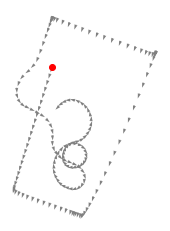

In [5]:
time = data['time'].values
dt = np.mean(np.diff(time))
x = data['x'].values
y = data['y'].values
psi = data['psi'].values

# For plotting arrows only
dx = np.cos(psi)
dy = np.sin(psi)

skip = 5
plt.quiver(x[::skip], y[::skip], dx[::skip], dy[::skip], color='gray', scale=30, width=0.01)
plt.plot(x[0], y[0], color='red', marker='o')
plt.gca().set_aspect(1.0)
plt.gca().set_axis_off()

The heading & velocity (in body-level frame) is consistent with the trajectory.

Note: I can use these velocities (or positions) + heading to perfectly reconstruct the trajectory via MPC, so I know these are correct (they come from GPS).

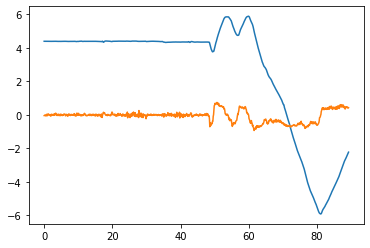

In [6]:
# Heading + angular velocity
psi_dot = data['psi_dot'].values
# psi_dot = pynumdiff.smooth_finite_difference.gaussiandiff(psi, dt, [10])[1]
plt.plot(time, psi)
plt.plot(time, psi_dot)

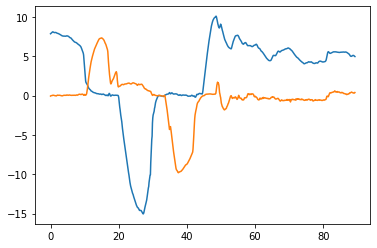

In [7]:
# Velocities in body-level frame (comes from transforming GPS velocity in global frame into body-level frame)
v_x = data['v_x'].values
v_y = data['v_y'].values
plt.plot(time, v_x)
plt.plot(time, v_y)

# Acceleration paradox
Now let's look at the acceleration in the body-level frame & compare it to the accelerometer data.

If we simply take the derivative of the body-level frame velocities, we can see that they match the kinematics of the trajectory

For instance, in the turning part of the trajectory both x & y accelerations are near 0.

In [10]:
v_x_dot = pynumdiff.smooth_finite_difference.gaussiandiff(v_x, dt, [10],options={'iterate': False})[1]
v_y_dot = pynumdiff.smooth_finite_difference.gaussiandiff(v_y, dt, [10],options={'iterate': False})[1]

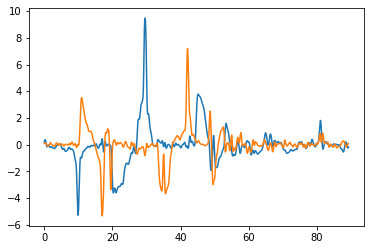

In [11]:
plt.plot(time, v_x_dot)
plt.plot(time, v_y_dot)

But what does the accelerometer data show? Let's start by getting the accelerometer data in the global frame (provided directly by the Matrice).

Note: You can also transform the raw IMU data (still in body-frame, but not body-level frame) into the global frame using the commented out code below.

In [12]:
# Acceleration in global frame directly from matrice
v_x_dot_global = data['v_x_dot_global'].values
v_y_dot_global = data['v_y_dot_global'].values
v_z_dot_global = data['v_z_dot_global'].values

In [13]:
# # This code transforms the raw IMU accelerometer data into the global frame acceleration
#
# # Raw acceleration
# ax = data['imu_acceleration_x'].values
# ay = data['imu_acceleration_y'].values
# az = data['imu_acceleration_z'].values
#
# # Quaternion
# qx = data['imu_quaternion_x'].values
# qy = data['imu_quaternion_y'].values
# qz = data['imu_quaternion_z'].values
# qw = data['imu_quaternion_w'].values
#
# # Transform to global frame
# from scipy.spatial.transform import Rotation as R
# Q = np.vstack((qx, qy, qz, qw)).T
# A = np.vstack((ax, ay, az)).T
# A_global = np.zeros_like(A)
# for k in range(Q.shape[0]):
#     R_matrix = R.from_quat(Q[k, :]).as_matrix()
#     a_body = A[k, :]
#     a_global = R_matrix @ a_body - np.array([0.0, 0.0, 9.81])
#     A_global[k, :] = a_global

Let's transform these global accelerations into the body-level frame and see if they match the derivative of $v_x$ and $v_y$

In [14]:
# Use rotation matrix used to derive drone dynamics
a_x_dot_from_imu = v_x_dot_global*np.cos(psi) + v_y_dot_global*np.sin(psi)
a_y_dot_from_imu = -v_x_dot_global*np.sin(psi) + v_y_dot_global*np.cos(psi)

The x accelerations match pretty well

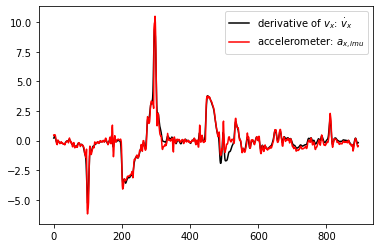

In [15]:
plt.plot(v_x_dot, color='black', label='derivative of $v_x$: $\dot{v}_x$')
plt.plot(a_x_dot_from_imu, color='red', label='accelerometer: $a_{x,imu}$')
plt.legend()

The y accelerations match pretty well when not turning, but are way off when turning. Note that the accelerometer shows huge spikes in $\dot{v}_y$ even when there is clearly not much acceleration in that direction when looking at the trajectory itself, and looking at the plot of $v_y$. So where are these spikes coming from? Please feel free to double-check my coordinate frames, but the fact that this only happens during turning led me to believe that my coorinate transformations are correct and I was just missing something else...

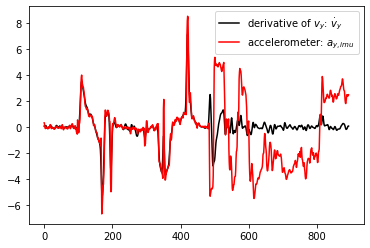

In [17]:
plt.plot(v_y_dot, color='black', label='derivative of $v_y$: $\dot{v}_y$')
plt.plot(a_y_dot_from_imu, color='red', label='accelerometer: $a_{y,imu}$')
plt.legend()

This is the point in my analysis where I thought I must have screwed something up, but after methodically checking everything I realized that this is indeed the correct accelerometer measurement in the correct frame, so why is it different?

Well, consider the dynamics for body-frame acceleration:

$\dot{v}_x = u_x + \dot{\psi} v_y$

$\dot{v}_y = u_y - \dot{\psi} v_x$

where $u_{x/y}$ represents all of the real forces on the system (thrust, damping, etc.) and $\dot{\psi} v_{x/y}$ represents Coriolis forces.

It turns out that these Coriolis terms appear in these equations for the purpose of canceling out the Coriolis forces that would otherwise show up in the acceleration dynamics and make it such that $\dot{v}$ does not equal $a$. In order to get our measured accelerations from the IMU to match, we need to add back in the Coriolis terms to $\dot{v}$ like this:

In [18]:
v_x_dot_from_imu = a_x_dot_from_imu + psi_dot*v_y
v_y_dot_from_imu = a_y_dot_from_imu - psi_dot*v_x

Reconstructing the body-level frame accelerations by removing the Coriolis effects results in a near perfect match between the IMU data and derivative of the GPS velocity data

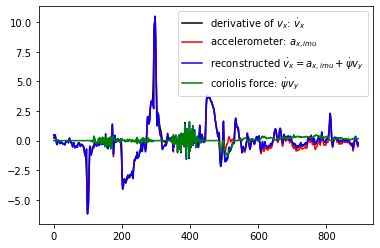

In [19]:
plt.plot(v_x_dot, color='black', label='derivative of $v_x$: $\dot{v}_x$')
plt.plot(a_x_dot_from_imu, color='red', label='accelerometer: $a_{x,imu}$')
plt.plot(v_x_dot_from_imu, color='blue', label='reconstructed $\dot{v}_x = a_{x,imu} + \dot{\psi} v_y$')
plt.plot(v_y*psi_dot, color='green', label='coriolis force: $\dot{\psi} v_y$')
plt.legend()

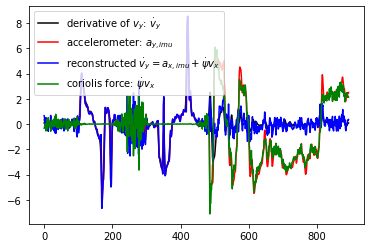

In [20]:
plt.plot(v_y_dot, color='black', label='derivative of $v_y$: $\dot{v}_y$')
plt.plot(a_y_dot_from_imu, color='red', label='accelerometer: $a_{y,imu}$')
plt.plot(v_y_dot_from_imu, color='blue', label='reconstructed $\dot{v}_y = a_{x,imu} + \dot{\psi} v_x$')
plt.plot(v_x*psi_dot, color='green', label='coriolis force: $\dot{\psi} v_x$')
plt.legend()

From this we can conclude that the accelerometer measurements actually represent the $u$ terms in our dynamics, which include the coriolis forces, but do not accurately represent the derivative of $v$. Note that the Coriolis forces only show up when turning and when the adjacent velocity is large. This is why the $\dot{v}_x$ curves match before correcting for Coriolis forces ($v_y$ is small...).

$u_x = \dot{v}_x - \dot{\psi} v_y = a_{x,imu}$

$u_y = \dot{v}_y + \dot{\psi} v_x = a_{y,imu}$

# Model considerations
When I run this trajectory through our model with MPC (accounting for Coriolis terms), I find that the IMU measurements are (as expected) a nearly perfect match for $u_{x/y}$ not $\dot{v}_{x/y}$. The problem? Well, we define our measurements in our model as $\dot{v}_{x/y}$ instead of $u_{x/y}$. This artificially injects observability into the ground speed, because we don't actually have anyway to measure $\dot{v}_{x/y}$. We should be using $u_{x/y}$, because this is what we get from the IMU, but this does not make ground speed observable during turns.